# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
!pip install simplejson
import simplejson as json


    100% |████████████████████████████████| 133kB 5.3MB/s ta 0:00:01


## Data Gathering
1. Directly downloading the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

2. Using the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
# soup = BeautifulSoup(response.content, 'lxml')
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

3. Using the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True,)

In [5]:
dictkeys = {'id','full_text','retweet_count','favorite_count'}
with open('tweet_json.txt', 'w') as file:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            exp_tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            data = exp_tweet._json
            dictionary = {key: data[key] for key in data.keys() & dictkeys}
            json.dump(dictionary, file)
            file.write('\n')
        except:
            print("unavailable tweet")

In [6]:
with open('tweet_json.txt', 'r') as file:
    lines = file.readlines()
data = [ ]
for line in lines:
    data.append(json.loads(line))
data_json = pd.DataFrame(data)

## Assessing Data
In this section, we are going to look for quality and tidiness issues using both visual and programmatic assessement.

##### Assessing twitter_archive dataframe

In [7]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


A visual assessment shows the presence of tweets without ratings, these tweets are either retweets or replies.  
This project is about making analyses and visualizations only about dog ratings so we will be deleting all rows and columns related to retweets and replies.

To avoid stumbling into issues related to retweets or replies entries, we will filter the dataset and continue assessing only original tweets' data.

In [8]:
#Filter for original tweets
original_tweets_filt =  twitter_archive.in_reply_to_status_id.isna() & twitter_archive.retweeted_status_id.isna()

#Keeping only original tweets
twitter_archive_original = twitter_archive.loc[original_tweets_filt]

<hr>

In [9]:
twitter_archive_original.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

The source column refers to the source application that was used to post the tweet, hence removing unnecessary HTML code and keeping only the source name would be more appropriate.
<hr>

Some strings like 'a' or 'an' are clearly not names and were extracted as names, this is defenetly caused by an error during the extraction process, the first letter of a name is usually written capitalized, thus, names having only lowercase characters are most likely invalid, so let's inspect them:

In [10]:
mask = twitter_archive_original.name.str.contains('^[a-z]', regex = True)
twitter_archive_original[mask].name.value_counts().sort_index()

a               55
actually         2
all              1
an               6
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             3
life             1
light            1
mad              1
my               1
not              2
officially       1
old              1
one              4
quite            3
space            1
such             1
the              8
this             1
unacceptable     1
very             4
Name: name, dtype: int64

All of the above strings are clearly not names.
<hr>

Scrolling a bit down we noticed that some rows have the string 'None' as name, these missing values for dog names should be replaced with np.nan's
<hr>

In [11]:
twitter_archive_original.rating_denominator.value_counts()

10     2080
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

The value counts for `rating_denominator` column shows that some ratings have denominators different from 10.
Since the ratings almost always have a denominator of 10, having ratings with denominator being different from 10 is a consistency problem that needs to be handled.  


Let's thoughtfully examine each rating text for each tweet with denominator different from 10 to see how to go about this probelm. 

In [12]:
#Filter for rating_denominator different from 10
denominator_filt = twitter_archive.rating_denominator!=10

for _,row in twitter_archive_original.loc[denominator_filt].iterrows():
    print('Tweet id:\n', row.tweet_id,'\nText:\n', row.text,'\nExtracted rating:\n', row.rating_numerator,'/', row.rating_denominator)
    print('-'*100)

Tweet id:
 820690176645140481 
Text:
 The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 
Extracted rating:
 84 / 70
----------------------------------------------------------------------------------------------------
Tweet id:
 810984652412424192 
Text:
 Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 
Extracted rating:
 24 / 7
----------------------------------------------------------------------------------------------------
Tweet id:
 758467244762497024 
Text:
 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 
Extracted rating:
 165 / 150
----------------------------------------------------------------------------------------------------
Tweet id:
 740373189193256964 
Text:
 After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. 

Looking carefully at the text and the rating extracted from it we can undersatnd few things:
- The tweet with tweet id *810984652412424192* is not a rating and can be safely removed.
- Some dates and other slash-separated numbers were mistakenly extracted as ratings.
- Some ratings are total ratings which is a way for rating multiple dogs and it was done by multiplying the rating denominator and the rating numerator by the number of dogs present in the image, this is shown here by rating denominators being multiples of ten, this shouldn't be a problem since we are interested in rating score and it will always stay the same.
<hr>

In [13]:
twitter_archive_original.rating_numerator.value_counts()

12      486
10      436
11      413
13      287
9       153
8        98
7        52
14       38
5        34
6        32
3        19
4        16
2         9
1         5
26        1
44        1
165       1
24        1
60        1
50        1
144       1
80        1
84        1
88        1
121       1
204       1
420       1
1776      1
27        1
45        1
75        1
99        1
0         1
Name: rating_numerator, dtype: int64

Since there weren't any specific restrictions on the rating denominator column, all values above can be considered valid, However, having only integers in there suggests that there might be incorrectly extracted decimal values.  

In [14]:
import re
decimals_filt = twitter_archive_original.text.str.contains('\d+[\.,]\d+\/\d+')
for _,row in twitter_archive_original[decimals_filt].iterrows():
    rating = re.findall('\d+[\.,]\d+\/\d+', row.text)
    if(len(rating)):
        print('Tweet id:\n', row.tweet_id,'\nText:\n', row.text,'\nExtracted rating:\n', rating[0])
        print('-'*100)

Tweet id:
 883482846933004288 
Text:
 This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 
Extracted rating:
 13.5/10
----------------------------------------------------------------------------------------------------
Tweet id:
 786709082849828864 
Text:
 This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 
Extracted rating:
 9.75/10
----------------------------------------------------------------------------------------------------
Tweet id:
 778027034220126208 
Text:
 This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq 
Extracted rating:
 11.27/10
----------------------------------------------------------------------------------------------------
Tweet id:
 680494726643068929 
Text:
 Here we have uncovered an entire

And it turned out that there are actually decimals that were incorrectly extracted.

As documented above, numerous ratings have been inccorectly extracted, and there definitely are more as well.  
Hopefully, all rating issues will be resolved after redoing the extraction properly.
<hr>

We can notice that dog stage is expressed over four columns (doggo, floofer, pupper and puppo) instead of one.  
this is a tideness problem that needs to be fixed.
<hr>

In [15]:
twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

`tweet_id` is used to uniquely identify each tweet and shouldn't be treated as number, so it needs to be converted to string instead of integer

`timestamp` and `retweeted_status_timestamp` columns are of type object instead of datetime.  
Since `retweeted_status_timestamp` column is related to retweets and will be eliminated, we only need to change the type for `timestamp` column.

##### Assessing image_predictions dataframe

In [16]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


The first problem we see is that the columns' names are vague; they don't provide clear information about the columns' contents.   
To improve clarity some column names may be renamed.
<hr>

Looking at p1, p2, and p3 columns which referes to the predictions for dog breed, we notice that the values sometimes starts with a capitalized letter and sometimes don't, standardizing all these values would be preferred.
<hr>

In [17]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Similar to twitter_archive dataframe `tweet_id` column datatype here is incorrectly inferred as integer instead of string
<hr>

image_predictions dataframe contains informations about images from rating tweets therfore it describes the same observational unit and should be combined with twitter_archive dataframe

##### Assessing data_json dataframe

In [18]:
data_json.head()

,favorite_count,full_text,id,retweet_count
0,33657,This is Phineas. He's a mystical boy. Only eve...,892420643555336193,6961
1,29178,This is Tilly. She's just checking pup on you....,892177421306343426,5265
2,21957,This is Archie. He is a rare Norwegian Pouncin...,891815181378084864,3463
3,36743,This is Darla. She commenced a snooze mid meal...,891689557279858688,7183
4,35140,This is Franklin. He would like you to stop ca...,891327558926688256,7707


In [19]:
data_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
favorite_count    2327 non-null int64
full_text         2327 non-null object
id                2327 non-null int64
retweet_count     2327 non-null int64
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


The same problem goes with the `tweet_id` column here, it has to be converted to string 
<hr>

The main goal of gathering the extra data and storing it into data_json dataframe is to add additional information about each dog-rating tweet, hence `favourite_count` and `retweet_count` variables should be part of the `twitter_archive` dataframe, otherwise, that would create a consistency problem. 

### Quality issues
- Tweets that are not original tweets in `twitter_archive`
- Irrelevant HTML code in source column in `twitter_archive`
- name column has values that are clearly not names in `twitter_archive`
- Dogs having the string 'None' as name in `twitter_archive`
- Invalid ratings in `twitter_archive`
- Wrong dtypes:
    - timestamp in `twitter_archive` should be converted to datetime
    - tweet_id column in `twitter_archive` should be converted to string
    - tweet_id column in `image_predictions` should be converted to string
    - id column in `data_json` should be converted to string 
- Some columns' names in `image_predictions` are vague
- Dog breeds in `image_predictions` are not standardized


### Tidiness issues
- Dog stages variable in `twitter_archive` should be expressed on one stage column, instead of four
- `image_predictions` dataframe should be combined with `twitter_archive` dataframe
- Retweet_count and favorite_count in `data_json` should be part of `twitter_archive` dataframe

## Cleaning Data
In this section, we are going to clean all the documented issues. 


In [20]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
data_json_clean = data_json.copy()

### Tweets that are not original tweets in `twitter_archive`

#### Define 
Removing replies and retweets:
- Remove any observations that include values in `in_reply_to_status_id` or `retweeted_status_id` columns 
- Delete columns corresponding to replies and retweets (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`)

#### Code

In [21]:
#Removing observations with values in in_reply_to_status_id or retweeted_status_id columns 
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isna() & twitter_archive_clean.retweeted_status_id.isna()]

#Deleting columns that corresponds to replies and retweets
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=True)

#### Test

In [22]:
twitter_archive_clean.shape[0]

2097

In [23]:
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Irrelevant HTML code in source column in `twitter_archive`

#### Define
Replace source column content with source name after extracting it from HTML a tag using Beautifulsoup

#### Code

In [24]:
#Importing BeautifulSoup
from bs4 import BeautifulSoup as bs

#Replacting source column value with the source name
twitter_archive_clean.source = twitter_archive_clean.source.apply(lambda x: bs(x, 'lxml').find('a').contents[0])

#### Test

In [25]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### name column has values that are clearly not names in `twitter_archive`

#### Define
Replace lowercased strings in name column with np.nan's

#### Code

In [26]:
# Filter for invalid names (lowercase strings)
mask = twitter_archive_clean.name.str.contains('^[a-z]', regex = True)

#Replace invalid strings with np.nan's
twitter_archive_clean.loc[mask,'name'] = np.nan

#### Test

In [27]:
twitter_archive_clean.name.str.contains('^[a-z]', regex = True).sum()

0

### Dogs having the string 'None' as name in `twitter_archive`

#### Define
Replace each 'None' in name column with np.nan 

#### Code

In [28]:
twitter_archive_clean.name.replace('None', np.nan, inplace=True)

#### Test

In [29]:
twitter_archive_clean[twitter_archive_clean.name == 'None'].shape[0]

0

In [30]:
twitter_archive_clean[twitter_archive_clean.name.isna()].shape[0]

707

### Invalid ratings in `twitter_archive`

#### Define
* Drop tweet with tweet id *10984652412424192*
* Correctly extract possible ratings for each tweet
* Choose the right rating from the extracted possible ratings for each tweet:
    1. Keep ratings with denominator being multiple of 10
    2. Visually assess and manually fix the remaining tricky ratings 

#### Code

In [31]:
#Dropping tweet with tweet id 10984652412424192
twitter_archive_clean.drop(twitter_archive_clean.query('tweet_id==810984652412424192').index, inplace=True)

In [32]:
#Importing re library
import re

#Correctly extracting possible ratings for each tweet
correct_ratings={}
for _,row in twitter_archive_clean.iterrows():
    pattern = '((?:\d+\.)?\d+)\/(\d+)'
    correct_ratings[row.tweet_id]=re.findall(pattern, row.text)
correct_ratings    

{892420643555336193: [('13', '10')],
 892177421306343426: [('13', '10')],
 891815181378084864: [('12', '10')],
 891689557279858688: [('13', '10')],
 891327558926688256: [('12', '10')],
 891087950875897856: [('13', '10')],
 890971913173991426: [('13', '10')],
 890729181411237888: [('13', '10')],
 890609185150312448: [('13', '10')],
 890240255349198849: [('14', '10')],
 890006608113172480: [('13', '10')],
 889880896479866881: [('13', '10')],
 889665388333682689: [('13', '10')],
 889638837579907072: [('12', '10')],
 889531135344209921: [('13', '10')],
 889278841981685760: [('13', '10')],
 888917238123831296: [('12', '10')],
 888804989199671297: [('13', '10')],
 888554962724278272: [('13', '10')],
 888078434458587136: [('12', '10')],
 887705289381826560: [('13', '10')],
 887517139158093824: [('14', '10')],
 887473957103951883: [('13', '10')],
 887343217045368832: [('13', '10')],
 887101392804085760: [('12', '10')],
 886983233522544640: [('13', '10')],
 886736880519319552: [('13', '10')],
 

In [33]:
#Excluding ratings with denominator not being multiple of 10
for key,ratings in correct_ratings.items():
    if(len(ratings)!=1):
        for rating in ratings:
            if(int(rating[1]) % 10 != 0):
                correct_ratings[key].remove(rating)

In [34]:
tricky_ratings = {}
tricky_ratings_count = 0
for key, value in correct_ratings.items():
    if(len(value)>1):
        tricky_ratings[key]=value
        tricky_ratings_count+=1
        
#Printing Tricky ratings
count_message = '{} tweets have more than one extracted possible rating:'.format(tricky_ratings_count)
print(count_message)
print('*'*len(count_message))
for _,row in twitter_archive_clean.query('tweet_id in @tricky_ratings.keys()').iterrows():
    print('Tweet id:\n', row.tweet_id,'\nText:\n', row.text,'\nExtracted rating:\n', tricky_ratings[row.tweet_id])
    print('-'*100)

24 tweets have more than one extracted possible rating:
*******************************************************
Tweet id:
 777684233540206592 
Text:
 "Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ 
Extracted rating:
 [('12', '10'), ('11', '10')]
----------------------------------------------------------------------------------------------------
Tweet id:
 747600769478692864 
Text:
 This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ 
Extracted rating:
 [('10', '10'), ('7', '10')]
----------------------------------------------------------------------------------------------------
Tweet id:
 722974582966214656 
Text:
 Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 
Extracted rating:
 [('4', '20'), ('13', '10')]
----------------------------------------------------------------------------------------------------
Tweet id:
 71643

Looking carefully at each text of the remaining tweets having 2 extracted valid ratings, we can notice that:
- The correct rating for tweet with id *722974582966214656* is 13/10 and the correct rating for tweet with id *716439118184652801* is 11/10.
- All other remaining tweets have multiple ratings of multiple dogs or objects.

In [35]:
#Fixing tricky ratings
correct_ratings[722974582966214656] = [('13', '10')]
correct_ratings[716439118184652801] = [('11', '10')]
#Fixed ratings
correct_ratings

{892420643555336193: [('13', '10')],
 892177421306343426: [('13', '10')],
 891815181378084864: [('12', '10')],
 891689557279858688: [('13', '10')],
 891327558926688256: [('12', '10')],
 891087950875897856: [('13', '10')],
 890971913173991426: [('13', '10')],
 890729181411237888: [('13', '10')],
 890609185150312448: [('13', '10')],
 890240255349198849: [('14', '10')],
 890006608113172480: [('13', '10')],
 889880896479866881: [('13', '10')],
 889665388333682689: [('13', '10')],
 889638837579907072: [('12', '10')],
 889531135344209921: [('13', '10')],
 889278841981685760: [('13', '10')],
 888917238123831296: [('12', '10')],
 888804989199671297: [('13', '10')],
 888554962724278272: [('13', '10')],
 888078434458587136: [('12', '10')],
 887705289381826560: [('13', '10')],
 887517139158093824: [('14', '10')],
 887473957103951883: [('13', '10')],
 887343217045368832: [('13', '10')],
 887101392804085760: [('12', '10')],
 886983233522544640: [('13', '10')],
 886736880519319552: [('13', '10')],
 

The remaining tweets correspond to multiple ratings. 
Extracting a correct rating for each dog from them is too hard to be done programmatically and will require some time and effort to be done manually, since they are only 22, they will be removed.

In [36]:
# tweets to remove 
tweets_to_remove = []
for key, value in correct_ratings.items():
    if(len(value)>1):
        tweets_to_remove.append(key)

In [37]:
#Replacing invalid rating with correct rating
for key, value in correct_ratings.items():
    
    new_rating_numerator = float(correct_ratings[key][0][0])
    new_rating_denominator = int(correct_ratings[key][0][1])
    
    twitter_archive_clean.loc[twitter_archive_clean.tweet_id==key,['rating_numerator','rating_denominator']] = new_rating_numerator,new_rating_denominator

In [38]:
#Removing tweets corresponding to multiple ratings
twitter_archive_clean = twitter_archive_clean.query('tweet_id not in @tweets_to_remove')

#### Test

In [39]:
twitter_archive_clean.rating_denominator.value_counts()

10     2063
80        2
50        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

In [40]:
twitter_archive_clean.rating_numerator.value_counts()

12.00      485
10.00      426
11.00      411
13.00      288
9.00       152
8.00        96
7.00        50
14.00       39
6.00        32
5.00        31
3.00        19
4.00        14
2.00         9
1.00         4
13.50        1
84.00        1
0.00         1
420.00       1
1776.00      1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
80.00        1
Name: rating_numerator, dtype: int64

### Wrong dtypes

#### Define
Convert timestamp column type to datetime using pandas.to_datetime()  
Convert the tweet id column's dtype in the three dataframes to a string using DataFrame.astype() method

#### Code

In [41]:
#Converting timestamp column dtype
twitter_archive_clean['timestamp']= pd.to_datetime(twitter_archive_clean['timestamp'])

#Converting the tweet id column's dtype in the three dataframes
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype('object')
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype('object')
data_json_clean.id = data_json_clean.id.astype('object')

#### Test

In [42]:
#Cheking timestamp column dtype
print(twitter_archive_clean['timestamp'].dtype)

#Cheking the tweet id column's dtype in the three dataframes
print(twitter_archive_clean.tweet_id.dtype)
print(image_predictions_clean.tweet_id.dtype)
print(data_json_clean.id.dtype)

datetime64[ns]
object
object
object


### Some columns' names in `image_predictions` are vague

#### Define
Rename the vaguely named columns as follows:  

`jpg_url` &rarr; img_url  
`img_num` &rarr; img_number  

`p1` &rarr; breed_pred1  
`p2` &rarr; breed_pred2  
`p3` &rarr; breed_pred3  

`p1_conf` &rarr; breed_pred1_conf  
`p2_conf` &rarr; breed_pred2_conf  
`p3_conf` &rarr; breed_pred3_conf  

`p1_dog` &rarr; breed_pred1_is_dog  
`p2_dog` &rarr; breed_pred2_is_dog  
`p3_dog` &rarr; breed_pred3_is_dog  


#### Code

In [43]:
image_predictions_clean.rename(columns={'jpg_url':'img_url', 'img_num':'img_number'}, inplace=True)
image_predictions_clean.columns = [column.replace("p", "breed_pred") if column != 'jpg_url' else column for column in list(image_predictions_clean.columns) ]
image_predictions_clean.columns = [column.replace("dog", "is_dog") for column in list(image_predictions_clean.columns) ]

#### Test

In [44]:
image_predictions_clean.columns

Index(['tweet_id', 'img_url', 'img_number', 'breed_pred1', 'breed_pred1_conf',
       'breed_pred1_is_dog', 'breed_pred2', 'breed_pred2_conf',
       'breed_pred2_is_dog', 'breed_pred3', 'breed_pred3_conf',
       'breed_pred3_is_dog'],
      dtype='object')

### Dog breeds in `image_predictions` are not standardized

#### Define
Replace uppercase with lowercase letters in dog breed columns (`breed_pred1`, `breed_pred2` and `breed_pred3`)

#### Code

In [45]:
image_predictions_clean.breed_pred1 = image_predictions_clean.breed_pred1.str.lower()
image_predictions_clean.breed_pred2 = image_predictions_clean.breed_pred2.str.lower()
image_predictions_clean.breed_pred3 = image_predictions_clean.breed_pred3.str.lower()

#### Test

In [46]:
image_predictions_clean[['breed_pred1','breed_pred2','breed_pred3']].head()

,breed_pred1,breed_pred2,breed_pred3
0,welsh_springer_spaniel,collie,shetland_sheepdog
1,redbone,miniature_pinscher,rhodesian_ridgeback
2,german_shepherd,malinois,bloodhound
3,rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,rottweiler,doberman


In [47]:
image_predictions_clean.breed_pred1.str.islower().sum() == image_predictions_clean.breed_pred2.str.islower().sum() == image_predictions_clean.breed_pred3.str.islower().sum() == image_predictions_clean.shape[0]

True

### Dog stages variable in `twitter_archive` should be expressed on one stage column, instead of four


#### Define

Replace missing values encoded as 'None' in `doggo`, `floofer`, `pupper` and `puppo` columns with empty strings and sum their content into a new single column called `stage`, replace empty strings in stage column with np.nan and finally drop the 4 old columns.

#### Code

In [48]:
#Dog stage columns
stage_columns = ['doggo','floofer','pupper','puppo']

#Replacing missing values encoded as the string 'None' with np.nan
twitter_archive_clean.loc[:,stage_columns] = twitter_archive_clean.loc[:,stage_columns].replace('None', '')

#Combine stage columns into a single column called stage
twitter_archive_clean['stage'] = twitter_archive_clean.loc[:,stage_columns].sum(axis=1)

#Replace empty string in stage column with np.nan
twitter_archive_clean['stage'] = twitter_archive_clean['stage'].replace('',np.nan)

#Dropping stage_columns
twitter_archive_clean = twitter_archive_clean.drop(stage_columns, axis=1)

#### Test

In [49]:
twitter_archive_clean.stage.value_counts()

pupper          219
doggo            72
puppo            23
floofer           9
doggopupper       9
doggopuppo        1
doggofloofer      1
Name: stage, dtype: int64

Tidiness problem fixed!  
However, looking at the value counts for stage column we notice that some ratings had been given two dog stages probably due to incorrect extraction of dog stage from the text.
This is a validity issue that will not be handled in this notebook.

### `image_predictions` dataframe should be combined with `twitter_archive` dataframe

#### Define
Merge `twitter_archive` and `image_predictions` dataframes on tweet_id using pandas.DataFrame.merge method

#### Code

In [50]:
#Merging twitter_archive and data_json dataframes
twitter_archive_clean = twitter_archive_clean.merge(image_predictions_clean, how='left', left_on='tweet_id', right_on='tweet_id')

#### Test

In [51]:
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'stage',
 'img_url',
 'img_number',
 'breed_pred1',
 'breed_pred1_conf',
 'breed_pred1_is_dog',
 'breed_pred2',
 'breed_pred2_conf',
 'breed_pred2_is_dog',
 'breed_pred3',
 'breed_pred3_conf',
 'breed_pred3_is_dog']

### Retweet_count and favorite_count in `data_json` should be part of `twitter_archive` dataframe

#### Define
Merge `tweet_archive` and `data_json` dataframes on tweet_id using pandas.DataFrame.merge method and delete duplicated columns (`full_text`, `id`)

#### Code

In [52]:
#Merging twitter_archive and data_json dataframes
twitter_archive_clean = twitter_archive_clean.merge(data_json_clean, how='left', left_on='tweet_id', right_on='id')

#Dropping duplicated columns
twitter_archive_clean = twitter_archive_clean.drop(['full_text','id'], axis=1)

#### Test

In [53]:
twitter_archive_clean.shape

(2074, 22)

In [54]:
list(twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'stage',
 'img_url',
 'img_number',
 'breed_pred1',
 'breed_pred1_conf',
 'breed_pred1_is_dog',
 'breed_pred2',
 'breed_pred2_conf',
 'breed_pred2_is_dog',
 'breed_pred3',
 'breed_pred3_conf',
 'breed_pred3_is_dog',
 'favorite_count',
 'retweet_count']

In [55]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,img_url,...,breed_pred1_conf,breed_pred1_is_dog,breed_pred2,breed_pred2_conf,breed_pred2_is_dog,breed_pred3,breed_pred3_conf,breed_pred3_is_dog,favorite_count,retweet_count
1011,713175907180089344,2016-03-25 01:29:21,Twitter for iPhone,Say hello to Opie and Clarkus. Clarkus fell as...,https://twitter.com/dog_rates/status/713175907...,10.0,10,Opie,NaN,https://pbs.twimg.com/media/CeW1tERWAAAA9Q2.jpg,...,0.503788,False,malamute,0.430624,True,siberian_husky,0.028454,True,4076.0,1326.0
237,836753516572119041,2017-03-01 01:42:39,Twitter for iPhone,This is Meera. She just heard about taxes and ...,https://twitter.com/dog_rates/status/836753516...,12.0,10,Meera,doggo,https://pbs.twimg.com/media/C5y-4VwWcAIcaoj.jpg,...,0.936882,False,academic_gown,0.020815,False,schipperke,0.011564,True,18054.0,4245.0
1850,670408998013820928,2015-11-28 01:08:55,Twitter for iPhone,This is Peanut. He was the World Table Tennis ...,https://twitter.com/dog_rates/status/670408998...,10.0,10,Peanut,NaN,https://pbs.twimg.com/media/CU3FbQgVAAACdCQ.jpg,...,0.999945,False,tennis_ball,0.000018,False,racket,0.000015,False,483.0,187.0
360,817423860136083457,2017-01-06 17:33:29,Twitter for iPhone,This is Ken. His cheeks are magic. 13/10 (IG: ...,https://twitter.com/dog_rates/status/817423860...,13.0,10,Ken,NaN,https://pbs.twimg.com/ext_tw_video_thumb/81742...,...,0.336200,False,samoyed,0.201358,True,eskimo_dog,0.186789,True,31678.0,13506.0
1305,689283819090870273,2016-01-19 03:10:43,Twitter for iPhone,Say hello to Chipson. He's aerodynamic af. No ...,https://twitter.com/dog_rates/status/689283819...,9.0,10,Chipson,NaN,https://pbs.twimg.com/media/CZDT-mZWsAEK9BH.jpg,...,0.267979,True,affenpinscher,0.199619,True,cairn,0.127469,True,3006.0,999.0


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [56]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

After wrangling our data, now we will try to get some insights about it by answring the following questions:  
- What is the most common dog stage?
- Which dog stage recieves the highest number of likes?
- Is there any relationship between the number of likes and the number of retweets?
- What are the 10 most common breeds of dogs?
- Among the 10 most common breeds of dogs which one recieves the highest rating?

### What is the most common dog stage?

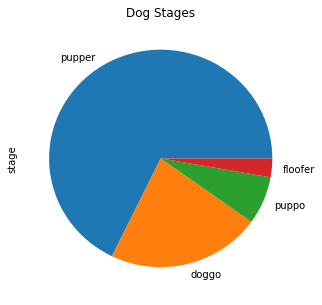

In [58]:
#List of dog satges
stages = ['floofer', 'doggo', 'pupper', 'puppo']
twitter_archive_clean.query('stage in @stages').stage.value_counts().plot(kind='pie', figsize=(5,5));
plt.title('Dog Stages');

The above plot shows that pupper is the most commun dog stage in this ratings dataset 

### Which dog stage recieves the highest number of likes?

Ratings with multiple dog stages will be ignored

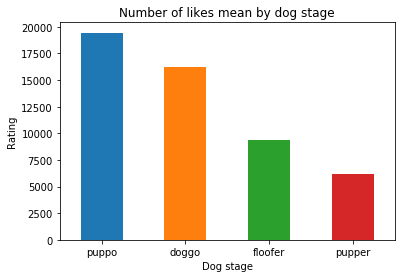

In [59]:
#Ploting descending favorite_count mean by dog stage 
twitter_archive_clean.query('stage in @stages').groupby('stage')['favorite_count'].mean().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Dog stage')
plt.xticks(rotation=0)
plt.ylabel('Rating')
plt.title('Number of likes mean by dog stage');

###  Is there any relationship between the number of likes and the number of retweets?

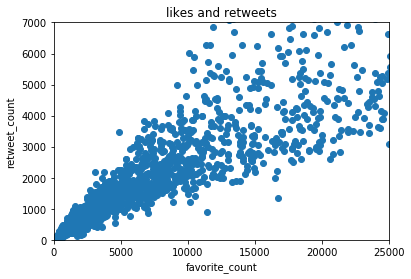

In [60]:
plt.scatter(twitter_archive_clean.favorite_count,twitter_archive_clean.retweet_count);
plt.xlabel('favorite_count');
plt.ylabel('retweet_count');
plt.title('likes and retweets');
plt.xlim(0, 25000);
plt.ylim(0, 7000);

The above scatter plot shows a clear positive relationship between the number of likes and the number of retweets

### What are the 10 most common breeds of dogs?

To answer question about breeds of dogs we are going to use the dog preed prediction provided by the first model

In [61]:
twitter_archive_clean.query("breed_pred1_is_dog == True").shape

(1442, 22)

In [62]:
commun10_breeds = twitter_archive_clean.query("breed_pred1_is_dog == True").breed_pred1.value_counts()[:10]
commun10_breeds

golden_retriever      135
labrador_retriever     93
pembroke               87
chihuahua              76
pug                    54
chow                   41
samoyed                40
toy_poodle             37
pomeranian             36
malamute               29
Name: breed_pred1, dtype: int64

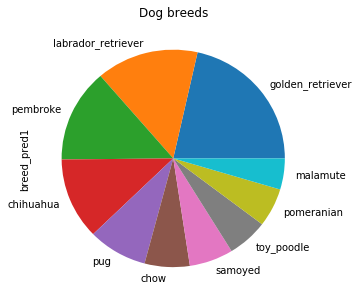

In [63]:
commun10_breeds.plot(kind='pie', figsize=(5,5));
plt.title('Dog breeds');

### Among the 10 most common breeds of dogs which one recieves the highest rating?

Before answring this question let's calculate the rating score and save it in a new column `rating` 

In [64]:
twitter_archive_clean['rating'] = twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator']

In [65]:
top_commun10_breeds = twitter_archive_clean.query("breed_pred1 in @commun10_breeds.index").groupby('breed_pred1').rating.mean().sort_values(ascending=False)
top_commun10_breeds

breed_pred1
samoyed               1.170000
golden_retriever      1.167037
chow                  1.160976
pembroke              1.145977
pomeranian            1.121528
labrador_retriever    1.112903
toy_poodle            1.105405
malamute              1.089655
chihuahua             1.071053
pug                   1.024074
Name: rating, dtype: float64

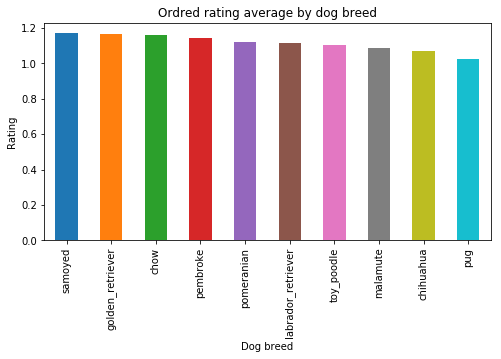

In [66]:
top_commun10_breeds.plot('bar', figsize=(8,4))
plt.title('Ordred rating average by dog breed');
plt.xlabel('Dog breed')
plt.ylabel('Rating');